In [7]:
import pandas as pd

# 1. CSV laden
df = pd.read_csv('input/googleplaystore.csv')

# Erste Infos zum Datensatz
print(f"Anzahl Zeilen/Spalten: {df.shape}")
print(df.info())
print(df.head())

# 2. Fehlerhafte Zeilen entfernen (Beispiel: 'Installs' mit Text)
# Installs: Entfernen von '+' und ',' und Umwandeln in Integer
df = df[df['Installs'].str.contains(r'^\d[\d,]*\+$', na=False)]

# 3. 'Installs' bereinigen
df['Installs'] = df['Installs'].str.replace('+', '', regex=False)
df['Installs'] = df['Installs'].str.replace(',', '', regex=False).astype(int)

# 4. 'Price' bereinigen (Entfernen von '$', Umwandeln in float)
df['Price'] = df['Price'].str.replace('$', '', regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 5. 'Reviews' in Integer umwandeln (ggf. ',' entfernen)
df['Reviews'] = df['Reviews'].astype(str).str.replace(',', '', regex=False)
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# 6. Fehlende Werte prüfen und ggf. entfernen
df.dropna(inplace=True)

# 7. Überblick nach Bereinigung
print(f"Nach Bereinigung: Anzahl Zeilen/Spalten: {df.shape}")
print(df.info())
print(df.head())


Anzahl Zeilen/Spalten: (10841, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & 

Random Forest RMSE: 2.908
Random Forest R²: 0.416


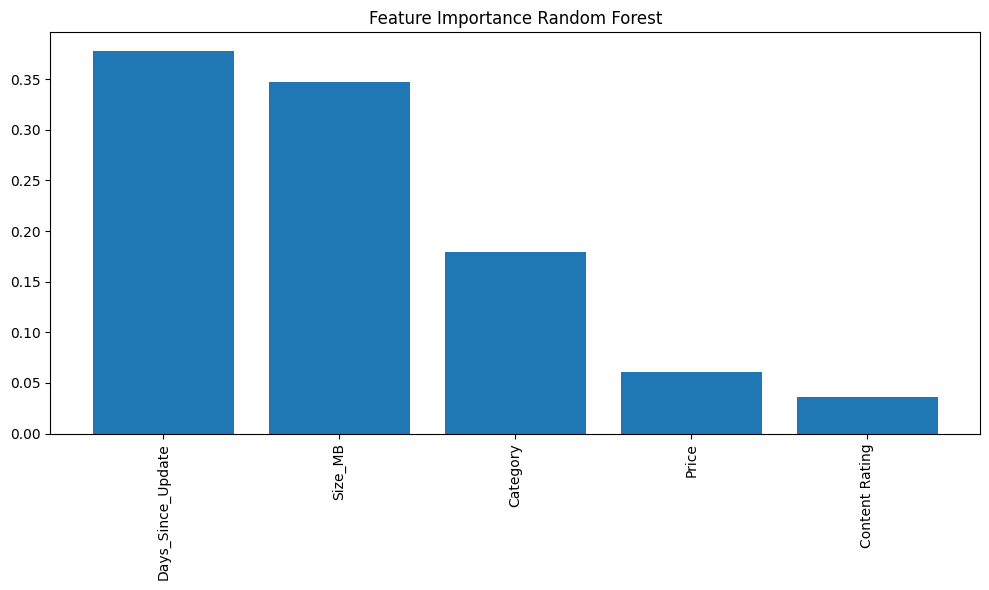

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Size in MB umwandeln (wie vorher)
def convert_size_to_mb(size):
    if isinstance(size, str):
        size = size.strip()
        if size.endswith('M'):
            return float(size[:-1])
        elif size.endswith('k'):
            return float(size[:-1]) / 1000
        elif size == 'Varies with device':
            return np.nan
        else:
            try:
                return float(size)
            except:
                return np.nan
    else:
        return np.nan

df['Size_MB'] = df['Size'].apply(convert_size_to_mb)
df['Size_MB'] = df['Size_MB'].fillna(df['Size_MB'].median())

# 2. Last Updated in Tage seit heute
df['Last Updated'] = pd.to_datetime(df['Last Updated'])
today = pd.to_datetime('today')
df['Days_Since_Update'] = (today - df['Last Updated']).dt.days

# 3. Label Encoding der kategorialen Variablen
label_encoders = {}
for col in ['Category', 'Content Rating']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4. Zielvariable log-transformieren
y = np.log1p(df['Installs'])

# 5. Features (ohne Installs, Reviews, Type, Genres)
features = ['Category', 'Size_MB', 'Price', 'Content Rating', 'Days_Since_Update']
X = df[features]

# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Random Forest initialisieren und trainieren
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 8. Vorhersage & Evaluation
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse:.3f}")
print(f"Random Forest R²: {r2:.3f}")

# 9. Feature Importance plotten
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance Random Forest")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


Decision Tree RMSE: 3.194
Decision Tree R²: 0.295


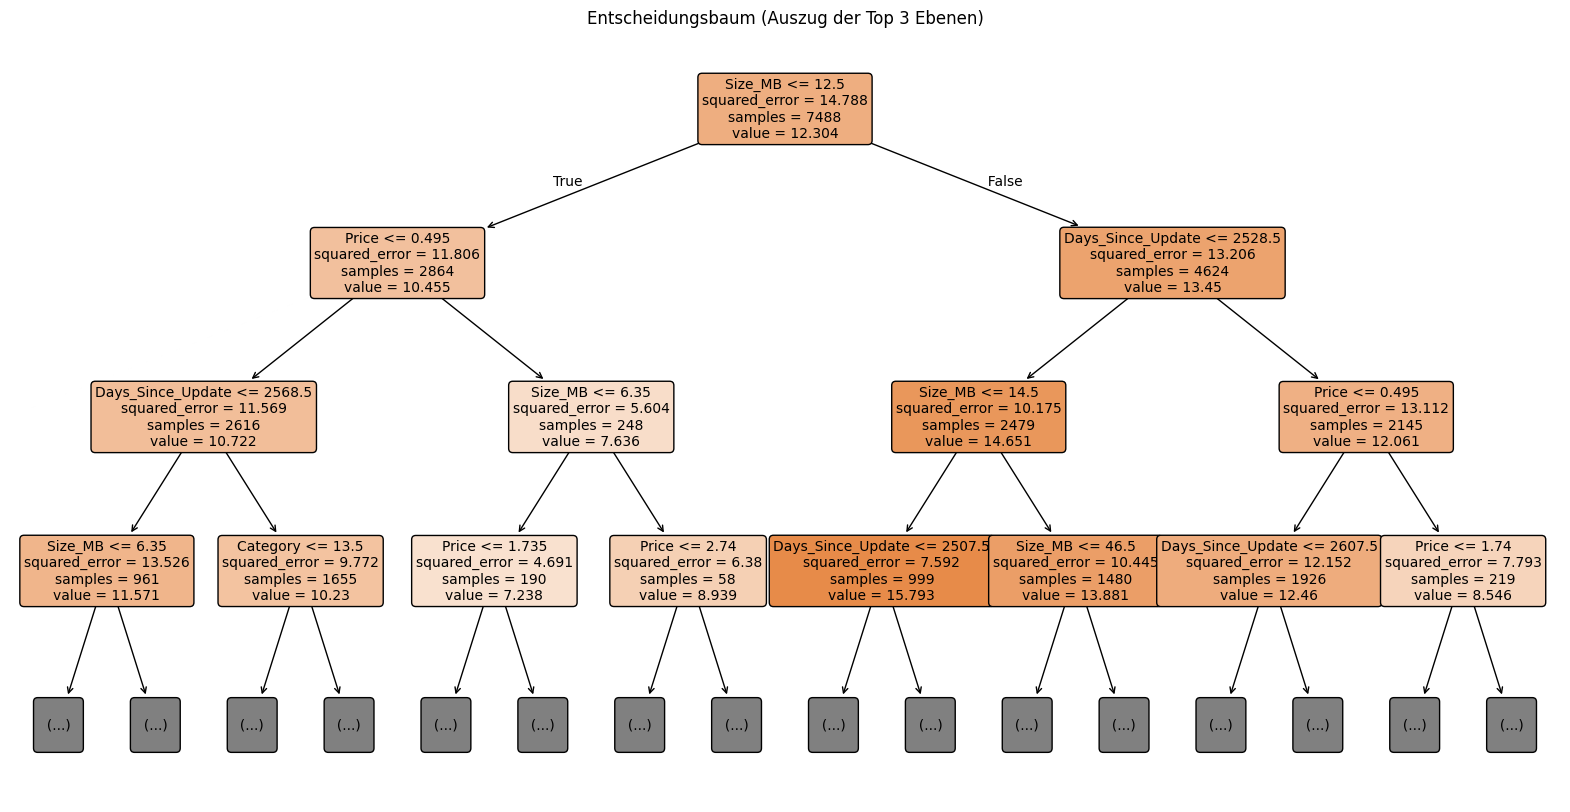

In [17]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Modell initialisieren (z.B. max_depth=5)
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)

# Trainieren
dt_model.fit(X_train, y_train)

# Vorhersagen
y_pred = dt_model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Decision Tree RMSE: {rmse:.3f}")
print(f"Decision Tree R²: {r2:.3f}")

plt.figure(figsize=(20,10))
plot_tree(
    dt_model,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  # z.B. nur die obersten 3 Ebenen, sonst wird der Baum zu groß
)
plt.title("Entscheidungsbaum (Auszug der Top 3 Ebenen)")
plt.show()
